In [2]:
%matplotlib inline

In [18]:
!mkdir results
!ls

drive  results	sample_data


In [17]:
from __future__ import print_function, division
import os
import glob
import argparse
import time
from copy import deepcopy

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from skimage import io, transform
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils, datasets
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion()   # interactive mode

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
dir = '/content/drive/My Drive/data'

# 데이터셋 탐색

image shape


*   cloudy, desert : (256, 256, 3)
*   green_area, water :  (64, 64, 3)






In [5]:
def show_image(dir_name):
    dir_path = dir + '/' + dir_name + '/'
    file_list = os.listdir(dir_path)

    for i in range(len(file_list)):
        plt.figure()
        img = io.imread(os.path.join(dir_path, file_list[i]))
        print(img.shape)
        plt.imshow(img)
        if i == 5:
            break    

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


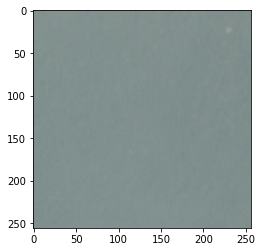

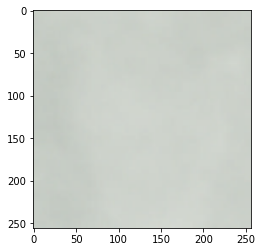

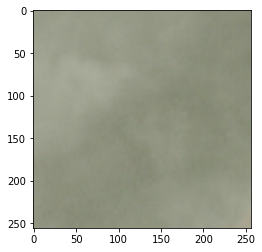

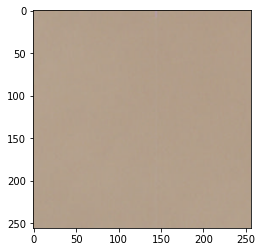

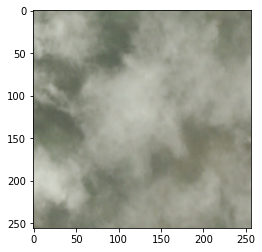

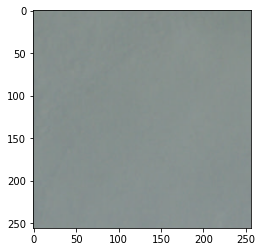

In [6]:
show_image('cloudy')

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


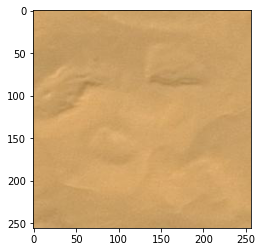

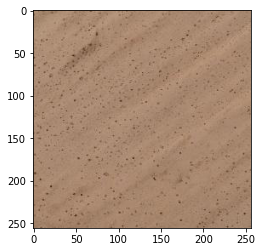

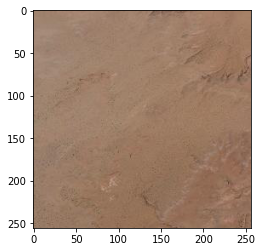

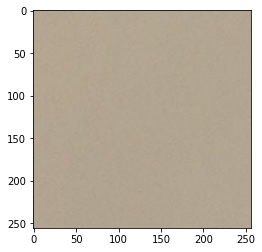

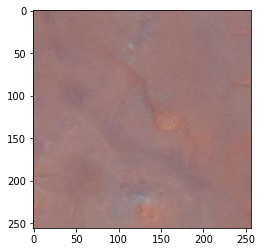

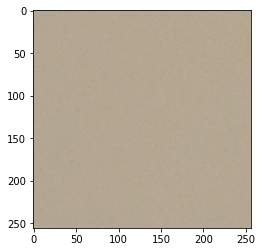

In [7]:
show_image('desert')

(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)


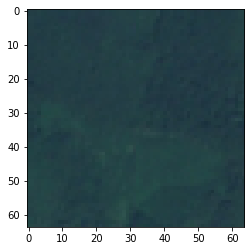

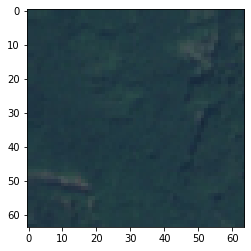

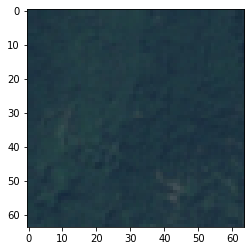

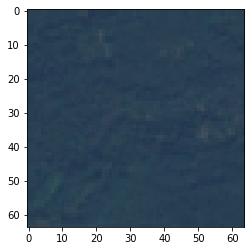

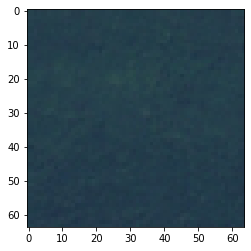

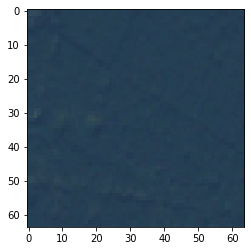

In [8]:
show_image('green_area')

(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)


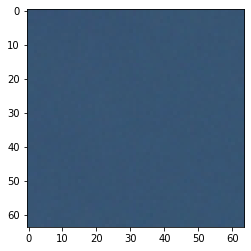

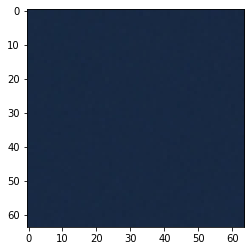

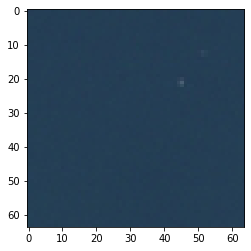

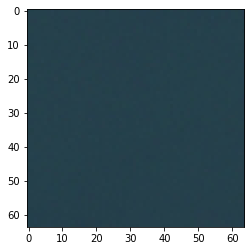

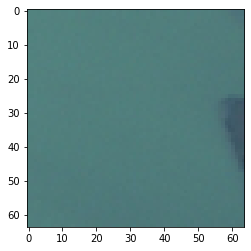

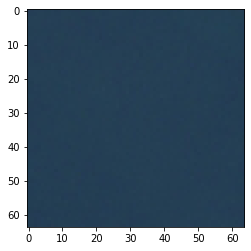

In [9]:
show_image('water')

## Torchvision - ImageFolder로 data_loader 만들기

In [10]:
data_transform = transforms.Compose([
    transforms.RandomSizedCrop(64),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
])

dataset = datasets.ImageFolder(root=dir,
                               transform=data_transform)
data_loader = torch.utils.data.DataLoader(dataset,batch_size=4, shuffle=True)

In [21]:
for i_batch, sample_batched in enumerate(data_loader):
    print(i_batch, sample_batched[0].shape, sample_batched[1].shape)
    if i_batch == 3:
        break

0 torch.Size([4, 3, 64, 64]) torch.Size([4])
1 torch.Size([4, 3, 64, 64]) torch.Size([4])
2 torch.Size([4, 3, 64, 64]) torch.Size([4])
3 torch.Size([4, 3, 64, 64]) torch.Size([4])


## Custom Dataset 이용하기

In [6]:
class SatelliteDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform

        self.cloudy_path = self.root_dir + '/cloudy'
        self.desert_path = self.root_dir + '/desert'
        self.green_area_path = self.root_dir +'/green_area'
        self.water_path = self.root_dir +'/water'

        self.cloudy_img_list = glob.glob(self.cloudy_path + '/*.jpg')
        self.desert_img_list = glob.glob(self.desert_path + '/*.jpg')
        self.green_area_img_list = glob.glob(self.green_area_path + '/*.jpg')
        self.water_img_list = glob.glob(self.water_path + '/*.jpg')

        self.img_list = self.cloudy_img_list + self.desert_img_list + self.green_area_img_list + self.water_img_list
        self.class_list = [0] * len(self.cloudy_img_list) + [1] * len(self.desert_img_list) + [2] * len(self.green_area_img_list) + [3] * len(self.water_img_list)
    
    def __len__(self):
        return len(self.class_list)

    def __getitem__(self, idx):
        img_path = self.img_list[idx]
        label = self.class_list[idx]
        img = io.imread(img_path)
        sample = {'img': img, 'label': label}

        if self.transform:
            sample = self.transform(sample)
        

        return sample

0 (256, 256, 3) 0
1 (256, 256, 3) 0
2 (256, 256, 3) 0
3 (256, 256, 3) 0


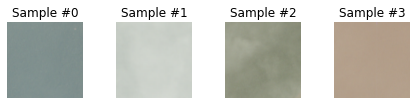

In [7]:
dataset = SatelliteDataset(root_dir=dir, transform = None)

fig = plt.figure()

for i in range(len(dataset)):
    sample = dataset[i]
    print(i, sample['img'].shape, sample['label'])
    
    ax = plt.subplot(1, 4, i+1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    plt.imshow(sample['img'])

    if i == 3:
        plt.show()
        break

In [8]:
class Rescale(object):
    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, label = sample['img'], sample['label']

        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        img = transform.resize(image, (new_h, new_w))

        return {'img': img, 'label': label }

class RandomCrop(object):
    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, sample):
        image, label = sample['img'], sample['label']

        h, w = image.shape[:2]
        new_h, new_w = self.output_size

        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)

        image = image[top: top + new_h,
                      left: left + new_w]

        return {'img': image, 'label': label}

class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, label = sample['img'], sample['label']

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C x H x W
        image = image.transpose((2, 0, 1))
        return {'img': torch.from_numpy(image),
                'label': label }

0 (256, 256, 3) 0
transformed:  torch.Size([3, 64, 64]) 0
1 (256, 256, 3) 0
transformed:  torch.Size([3, 64, 64]) 0
2 (256, 256, 3) 0
transformed:  torch.Size([3, 64, 64]) 0
3 (256, 256, 3) 0
transformed:  torch.Size([3, 64, 64]) 0


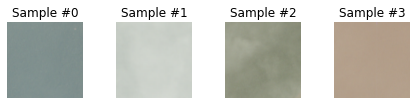

In [9]:
# scale = Rescale(64)
composed = transforms.Compose([Rescale(128), RandomCrop(64), ToTensor()])
fig = plt.figure()

for i in range(len(dataset)):
    sample = dataset[i]
    print(i, sample['img'].shape, sample['label'])

    transformed_sample = composed(sample)
    print('transformed: ', transformed_sample['img'].shape, transformed_sample['label'])
    
    ax = plt.subplot(1, 4, i+1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    plt.imshow(sample['img'])

    if i == 3:
        plt.show()
        break

In [10]:
transformed_dataset = SatelliteDataset(root_dir=dir,
                                       transform = transforms.Compose([
                                            Rescale(128),
                                            RandomCrop(64),
                                            ToTensor()                                
                                       ]))

for i in range(len(transformed_dataset)):
    sample = transformed_dataset[i]

    print(i, sample['img'].size(), sample['label'])
    if i == 3:
        break

0 torch.Size([3, 64, 64]) 0
1 torch.Size([3, 64, 64]) 0
2 torch.Size([3, 64, 64]) 0
3 torch.Size([3, 64, 64]) 0


0 torch.Size([4, 3, 64, 64]) tensor([3, 0, 2, 0])
1 torch.Size([4, 3, 64, 64]) tensor([2, 2, 2, 1])
2 torch.Size([4, 3, 64, 64]) tensor([2, 2, 2, 1])
3 torch.Size([4, 3, 64, 64]) tensor([3, 3, 3, 3])


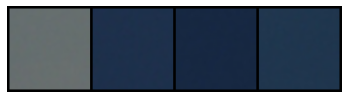

In [11]:
dataloader = DataLoader(transformed_dataset, batch_size=4, shuffle=True)

for i_batch, sample_batched in enumerate(dataloader):
    print(i_batch, sample_batched['img'].size(), sample_batched['label'])

    if i_batch == 3:
        plt.figure()
        grid = utils.make_grid(sample_batched['img'])
        plt.imshow(grid.numpy().transpose(1,2,0))
        plt.axis('off')
        plt.ioff()
        plt.show()
        break

# Data Preparation

In [12]:
print(len(transformed_dataset))

5633


In [14]:
trainset, valset, testset = torch.utils.data.random_split(transformed_dataset,[4000, 1000, 633])
partition = {'train': trainset, 'val': valset, 'test': testset}

# Model Architecture

In [15]:
def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)

def conv1x1(in_planes, out_planes, stride=1):
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, 
                     bias=False)

In [19]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

In [20]:
class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = conv1x1(inplanes, planes)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = conv3x3(planes, planes, stride)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = conv1x1(planes, planes * self.expansion)
        self.bn3 = nn.BatchNorm2d(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

In [23]:
class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes=4, zero_init_residual=False):
        super(ResNet, self).__init__()
        self.inplanes = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

In [28]:
net = ResNet(BasicBlock, (3,3,3,3))
x = torch.randn(2, 3, 64, 64)
y = net(x)
print(y.size())
print(y)

torch.Size([2, 4])
tensor([[-0.1753, -1.0655,  0.2451, -0.5153],
        [-0.2658, -0.8131,  0.5109, -0.7952]], grad_fn=<AddmmBackward>)


# Train, Validate, Test and Experiment

In [61]:
# args.exp_name = "exp1_block_layers"

args.block = BasicBlock
args.layers = (1, 1, 1, 1)
args.zero_init_residual = False

args.optim = 'RMSprop'
args.lr = 0.0015
args.l2 = 0.001
args.epoch = 2

args.train_batch_size = 32
args.test_batch_size = 1024

In [66]:
optimizer = optim.RMSprop(net.parameters(), lr=0.001, weight_decay=0.0001)
criterion = nn.CrossEntropyLoss()
train(net, partition, optimizer, criterion, args)

(ResNet(
   (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
   (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (relu): ReLU(inplace=True)
   (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
   (layer1): Sequential(
     (0): BasicBlock(
       (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
       (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       (relu): ReLU(inplace=True)
       (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
       (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     )
     (1): BasicBlock(
       (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
       (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       (relu): ReLU

In [65]:
def train(net, partition, optimizer, criterion, args):
    trainloader = torch.utils.data.DataLoader(partition['train'], 
                                              batch_size=args.train_batch_size, 
                                              shuffle=True, num_workers=2)
    net.train()
    net.to("cuda:0")

    correct = 0
    total = 0
    train_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        optimizer.zero_grad()

        # get the inputsa
        inputs, labels = data['img'], data['label']
        inputs = inputs.to("cuda:0").float()
        labels = labels.to("cuda:0").long()
        outputs = net(inputs)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = train_loss / len(trainloader)
    train_acc = 100 * correct / total
    return net, train_loss, train_acc

In [79]:
def validate(net, partition, criterion, args):
    valloader = torch.utils.data.DataLoader(partition['val'], 
                                            batch_size=args.test_batch_size, 
                                            shuffle=False, num_workers=2)
    net.eval()
    net.to("cuda:0")
    
    correct = 0
    total = 0
    val_loss = 0 
    with torch.no_grad():
        for data in valloader:
            inputs, labels = data['img'], data['label']
            inputs = inputs.to("cuda:0").float()
            labels = labels.to("cuda:0").long()
            outputs = net(inputs)

            loss = criterion(outputs, labels)
            
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        val_loss = val_loss / len(valloader)
        val_acc = 100 * correct / total
    return val_loss, val_acc

In [81]:
def test(net, partition, args):
    testloader = torch.utils.data.DataLoader(partition['test'], 
                                             batch_size=args.test_batch_size, 
                                             shuffle=False, num_workers=2)
    net.eval()
    net.to("cuda:0")
    
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            inputs, labels = data['img'], data['label']
            inputs = inputs.to("cuda:0").float()
            labels = labels.to("cuda:0").long()

            outputs = net(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        test_acc = 100 * correct / total
    return test_acc

In [74]:
def experiment(partition, args):
  
    net = ResNet(block=args.block, layers=args.layers, num_classes=4, zero_init_residual=args.zero_init_residual)
    net.to("cuda:0")

    criterion = nn.CrossEntropyLoss()
    if args.optim == 'SGD':
        optimizer = optim.SGD(net.parameters(), lr=args.lr, weight_decay=args.l2)
    elif args.optim == 'RMSprop':
        optimizer = optim.RMSprop(net.parameters(), lr=args.lr, weight_decay=args.l2)
    elif args.optim == 'Adam':
        optimizer = optim.Adam(net.parameters(), lr=args.lr, weight_decay=args.l2)
    else:
        raise ValueError('In-valid optimizer choice')
    
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []
        
    for epoch in range(args.epoch): 
        ts = time.time()
        net, train_loss, train_acc = train(net, partition, optimizer, criterion, args)
        val_loss, val_acc = validate(net, partition, criterion, args)
        te = time.time()
        
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)
        
        print('Epoch {}, Acc(train/val): {:2.2f}/{:2.2f}, Loss(train/val) {:2.2f}/{:2.2f}. Took {:2.2f} sec'.format(epoch, train_acc, val_acc, train_loss, val_loss, te-ts))
        
    test_acc = test(net, partition, args)    
    
    result = dict()
    result['train_losses'] = train_losses
    result['val_losses'] = val_losses
    result['train_accs'] = train_accs
    result['val_accs'] = val_accs
    result['train_acc'] = train_acc
    result['val_acc'] = val_acc
    result['test_acc'] = test_acc
    return vars(args), result

# Manage Experiment Result

In [114]:
import hashlib
import json
from os import listdir
from os.path import isfile, join
import pandas as pd

def save_exp_result(setting, result):
    exp_name = setting['exp_name']
    del setting['epoch']
    del setting['test_batch_size']
    if str(setting['block']) == "<class '__main__.BasicBlock'>":
        setting['block'] = 'BasicBlock'
    else:
        setting['block'] = 'Bottleneck'

    hash_key = hashlib.sha1(str(setting).encode()).hexdigest()[:6]
    filename = './results/{}-{}.json'.format(exp_name, hash_key)
    result.update(setting)
    with open(filename, 'w') as f:
        json.dump(result, f)
    
def load_exp_result(exp_name):
    dir_path = './results'
    filenames = [f for f in listdir(dir_path) if isfile(join(dir_path, f)) if '.json' in f]
    list_result = []
    for filename in filenames:
        if exp_name in filename:
            with open(join(dir_path, filename), 'r') as infile:
                results = json.load(infile)
                list_result.append(results)
    df = pd.DataFrame(list_result) # .drop(columns=[])
    return df

# Experiment

In [ ]:
seed = 123
np.random.seed(seed)
torch.manual_seed(seed)

parser = argparse.ArgumentParser()
args = parser.parse_args("")
args.exp_name = "exp1_block_layers"

# args.block = BasicBlock
# args.layers = (1, 1, 1, 1)
args.zero_init_residual = False

args.optim = 'RMSprop'
args.lr = 0.0015
args.l2 = 0.001
args.epoch = 10

args.train_batch_size = 64
args.test_batch_size = 64

#====== Experiment Variable ====== #
name_var1 = 'block'
name_var2 = 'layers'
list_var1 = [ BasicBlock, Bottleneck ]
list_var2 = [ (2,2,2,2), (3, 2, 2, 3), (3,3,3,3) ]

# setting, result = experiment(partition, deepcopy(args))
# save_exp_result(setting, result)

for var1 in list_var1:
    for var2 in list_var2:
        setattr(args, name_var1, var1)
        setattr(args, name_var2, var2)
        print(args)
                
        setting, result = experiment(partition, deepcopy(args))
        save_exp_result(setting, result)

Namespace(block=<class '__main__.BasicBlock'>, epoch=10, exp_name='exp1_block_layers', l2=0.001, layers=(2, 2, 2, 2), lr=0.0015, optim='RMSprop', test_batch_size=64, train_batch_size=64, zero_init_residual=False)
Epoch 0, Acc(train/val): 61.83/63.20, Loss(train/val) 1.02/0.56. Took 51.63 sec
Epoch 1, Acc(train/val): 84.75/90.20, Loss(train/val) 0.39/0.28. Took 51.20 sec
Epoch 2, Acc(train/val): 85.00/73.40, Loss(train/val) 0.38/0.82. Took 50.33 sec
Epoch 3, Acc(train/val): 86.78/87.20, Loss(train/val) 0.34/0.38. Took 50.90 sec
Epoch 4, Acc(train/val): 87.42/85.40, Loss(train/val) 0.32/0.39. Took 51.56 sec
Epoch 5, Acc(train/val): 87.58/82.60, Loss(train/val) 0.33/0.43. Took 52.72 sec
Epoch 6, Acc(train/val): 88.30/72.60, Loss(train/val) 0.31/0.57. Took 52.06 sec
Epoch 7, Acc(train/val): 85.47/70.90, Loss(train/val) 0.43/0.63. Took 51.65 sec
Epoch 8, Acc(train/val): 86.75/74.30, Loss(train/val) 0.33/0.68. Took 51.90 sec
Epoch 9, Acc(train/val): 86.70/66.70, Loss(train/val) 0.34/1.23. To

In [ ]:
import winsound as sd
def beepsound():
    fr = 2000    # range : 37 ~ 32767
    du = 1000     # 1000 ms ==1second
    sd.Beep(fr, du) # winsound.Beep(frequency, duration)
beepsound()

# Visualization Utility

In [117]:
def plot_acc(var1, var2, df):

    fig, ax = plt.subplots(1, 3)
    fig.set_size_inches(15, 6)
    sns.set_style("darkgrid", {"axes.facecolor": ".9"})

    sns.barplot(x=var1, y='train_acc', hue=var2, data=df, ax=ax[0])
    sns.barplot(x=var1, y='val_acc', hue=var2, data=df, ax=ax[1])
    sns.barplot(x=var1, y='test_acc', hue=var2, data=df, ax=ax[2])
    
    ax[0].set_title('Train Accuracy')
    ax[1].set_title('Validation Accuracy')
    ax[2].set_title('Test Accuracy')
    
def plot_loss_variation(var1, var2, df, **kwargs):

    list_v1 = df[var1].unique()
    list_v2 = df[var2].unique()
    list_data = []

    for value1 in list_v1:
        for value2 in list_v2:
            row = df.loc[df[var1]==value1]
            row = row.loc[df[var2]==value2]

            train_losses = list(row.train_losses)[0]
            val_losses = list(row.val_losses)[0]

            for epoch, train_loss in enumerate(train_losses):
                list_data.append({'type':'train', 'loss':train_loss, 'epoch':epoch, var1:value1, var2:value2})
            for epoch, val_loss in enumerate(val_losses):
                list_data.append({'type':'val', 'loss':val_loss, 'epoch':epoch, var1:value1, var2:value2})

    df = pd.DataFrame(list_data)
    g = sns.FacetGrid(df, row=var2, col=var1, hue='type', **kwargs)
    g = g.map(plt.plot, 'epoch', 'loss', marker='.')
    g.add_legend()
    g.fig.suptitle('Train loss vs Val loss')
    plt.subplots_adjust(top=0.89) 
    
def plot_acc_variation(var1, var2, df, **kwargs):
    list_v1 = df[var1].unique()
    list_v2 = df[var2].unique()
    list_data = []

    for value1 in list_v1:
        for value2 in list_v2:
            row = df.loc[df[var1]==value1]
            row = row.loc[df[var2]==value2]

            train_accs = list(row.train_accs)[0]
            val_accs = list(row.val_accs)[0]
            test_acc = list(row.test_acc)[0]

            for epoch, train_acc in enumerate(train_accs):
                list_data.append({'type':'train', 'Acc':train_acc, 'test_acc':test_acc, 'epoch':epoch, var1:value1, var2:value2})
            for epoch, val_acc in enumerate(val_accs):
                list_data.append({'type':'val', 'Acc':val_acc, 'test_acc':test_acc, 'epoch':epoch, var1:value1, var2:value2})

    df = pd.DataFrame(list_data)
    g = sns.FacetGrid(df, row=var2, col=var1, hue='type', **kwargs)
    g = g.map(plt.plot, 'epoch', 'Acc', marker='.')

    def show_acc(x, y, metric, **kwargs):
        plt.scatter(x, y, alpha=0.3, s=1)
        metric = "Test Acc: {:1.3f}".format(list(metric.values)[0])
        plt.text(0.05, 0.95, metric,  horizontalalignment='left', verticalalignment='center', transform=plt.gca().transAxes, bbox=dict(facecolor='yellow', alpha=0.5, boxstyle="round,pad=0.1"))
    g = g.map(show_acc, 'epoch', 'Acc', 'test_acc')

    g.add_legend()
    g.fig.suptitle('Train Accuracy vs Val Accuracy')
    plt.subplots_adjust(top=0.89)